In [1]:
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import FunctionalGroups
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks


# Functions

In [2]:
def create_random_compositions(elements, num_of_composition):
    '''
    Creates the random compositions for the training data
    Args
        elements: The elements to include in the training set
        num_of_compositions: the number of training data examples to create
    Returns:
        composition: a dictionary of the emements present and their percentages
    '''
    bool_list = [True, False]
    is_present = []
    composition =[]
    for i in range(num_of_composition):
        tmp = []
        for j in range(len(elements)):
            tmp.append(random.choice(bool_list))

        if True not in tmp:
            tmp[random.randint(0,len(elements)-1)] = True
        is_present.append(tmp)

    for i in range(num_of_composition):
        tmp = {}
        total = 0
        for j in range(len(elements)):
            if not is_present[i][j]:
                continue
            x =  random.random()
            tmp[elements[j]] = x
            total += x

        tmp = {k:(v/total) for k,v in tmp.items()}
        composition.append(tmp)

    return composition


def chop_and_shift(spectrum, ranges, max_shift):
    '''
    Cuts out the regions of the spectrum from the main spectrum and applys a random shift +/- to the entire spectrum
    Args:
        spectrum
        ranges: the indices of the ranges to take out of the spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        spectrum
    '''

    indices = []
    shift = random.randint(-max_shift, max_shift)
    for i in range(len(ranges)):
        inds = list(range(ranges[i][0]+shift, ranges[i][1]+shift))
        for ind in inds:
            indices.append(ind)
    return spectrum[indices]


def apply_horizontal_shift(spectrum, max_shift):
    '''
    Applies a random horizontal shift to the entire spectrum sequence.
    Args:
        spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        shifted_spectrum
    '''
    shift = random.randint(-max_shift, max_shift)
    # Create an array of zeros with the same length as the original spectrum
    shifted_spectrum = np.zeros_like(spectrum)

    if shift > 0:
        # Shift to the right
        shifted_spectrum[shift:] = spectrum[:-shift]
    elif shift < 0:
        # Shift to the left
        shifted_spectrum[:shift] = spectrum[-shift:]
    else:
        # No shift, return the original spectrum
        shifted_spectrum = spectrum.copy()

    shifted_spectrum = shifted_spectrum[:len(spectrum)]


    return shifted_spectrum


def get_spec(path_to_file):
    """
    Extract the sequential intensity values (CPS) from Excel files.
    """
    df_f = pd.read_excel(path_to_file, sheet_name='All')
    return np.array(df_f['CPS'])

def get_binding_energies(path_to_file):
    """
    Extract the binding energy column from Excel files.
    """
    df_f = pd.read_excel(path_to_file, sheet_name='All')
    return np.array(df_f['Binding Energy'])

def get_label(path_to_file):
    """
    Extract the labels from Excel files.
    """
    df_f = pd.read_excel(path_to_file)
    labels = np.array(df_f['Number'])
    return np.nan_to_num(labels)

def get_SMILES(path_to_file):
    '''
    extract SMILES string from Excel fil
    '''
    df_f = pd.read_excel(path_to_file)
    SMILES = str((df_f.columns[0]))
    return SMILES

def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

def label_converter(label):
    '''
    Converts the encoded label lists into a readable format

    '''
    CEL_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx') 
    label_dict = get_label_dict(CEL_path)
    fg_counts = []
    fg_count = "" 

    for i, e in enumerate(label):
        if pd.isna(e):
            e = 0
        if e != 0.0:
            fg_count = f'{e:.2f}  {label_dict[i]}'
            fg_counts.append(fg_count)

    return fg_counts
def create_uniform_energy_grid(start_energy, end_energy, increment=0.1):
    """
    Create a uniform energy grid with a fixed increment.
    
    Args:
        start_energy: Starting energy value.
        end_energy: Ending energy value.
        increment: Energy increment (default is 0.1 eV).
    
    Returns:
        energy_range: Uniform energy grid as a NumPy array.
    """
    return np.arange(start_energy, end_energy + increment, increment)

def fill_spectral_data(cps_data, be_data, start_energy, end_energy, increment=0.1):
    """
    Fill gaps in the spectral data with zeroes to ensure uniform energy increments.
    
    Args:
        cps_data: Dictionary of CPS values for each polymer.
        be_data: Dictionary of binding energy values for each polymer.
        start_energy: Starting energy value for the uniform grid.
        end_energy: Ending energy value for the uniform grid.
        increment: Energy increment (default is 0.1 eV).
    
    Returns:
        filled_data: Dictionary with filled CPS data for each polymer.
    """
    # Create the uniform energy grid
    energy_range = create_uniform_energy_grid(start_energy, end_energy, increment)
    filled_data = {}

    for polymer, cps_values in cps_data.items():
        # Initialize a new array filled with zeroes
        filled_cps = np.zeros_like(energy_range)

        # Fill the new array with existing CPS values
        for i, energy in enumerate(energy_range):
            # Find the index of the energy in the BE data
            index = np.where(np.isclose(be_data[polymer], energy, atol=0.01))[0]  # Use tolerance for floating-point comparison
            if index.size > 0:  # If the energy exists in the BE data
                filled_cps[i] = cps_values[index[0]]  # Assign the corresponding CPS value

        # Store the filled CPS data for the polymer
        filled_data[polymer] = filled_cps

    return filled_data

def open_all_xps_files(data_path, elements=None):
    """
    Open and read in the data from the experimental spectra.
    
    Args:
        data_path: Path to the data directory.
        elements: List of specific polymers to use (if None, all polymers are used).
    
    Returns:
        spectral_data: Dictionary of CPS values for each polymer.
        label_data: Dictionary of labels for each polymer.
        ids: List of polymer IDs.
        be_data: Dictionary of binding energy values for each polymer.
    """
    if not elements:
        all_folders = os.listdir(data_path)
    else:
        all_folders = [e for e in elements]

    spectral_data = {}
    label_data = {}
    be_data = {}
    SMILES_data = {}
    ids = []
    failed_polymers = []


    for folder in all_folders:
        folder_spec_format = folder[:folder.rfind(' (')]
        folder_label_format = folder[folder.rfind(' (') + 2:folder.rfind(')')]

        filename_spec = folder_spec_format + '.xlsx'
        filename_label = folder_label_format + '_FG.xlsx'
        filename_SMILES = folder_label_format + '_SMILES.xlsx'

        spec_path = os.path.join(data_path, folder, filename_spec)
        label_path = os.path.join(data_path, folder, filename_label)
        SMILES_path = os.path.join(data_path, folder, filename_SMILES)

        if not os.path.isfile(label_path):
            filename_label = folder + '_FG.xlsx'
            label_path = os.path.join(data_path, folder, filename_label)

            filename_SMILES = folder + '_SMILES.xlsx'
            SMILES_path =  os.path.join(data_path, folder, filename_SMILES)

        if not os.path.isfile(spec_path):
            filename_spec = folder + '.xlsx'
            spec_path = os.path.join(data_path, folder, filename_spec)

        if os.path.isfile(spec_path) and os.path.isfile(label_path) and os.path.isfile(SMILES_path):
            print('Material ID:', folder)
            data_spec = get_spec(spec_path)
            data_label = get_label(label_path)
            data_be = get_binding_energies(spec_path)
            data_SMILES = get_SMILES(SMILES_path)

            data_label = np.nan_to_num(data_label)
            ids.append(folder)

            spectral_data[folder] = data_spec
            label_data[folder] = data_label
            be_data[folder] = data_be
            SMILES_data[folder] = data_SMILES
        else:
            failed_polymers.append(folder)
    
    if failed_polymers: 
        print(f'failed to load polymers: {failed_polymers}') 

    return spectral_data, label_data, ids, be_data, SMILES_data

def old_count_carbons(mol):
    """
    Count the number of sp3 carbon atoms in a molecule. including heteroatoms
    
    Args:
        mol: RDKit molecule object.
    
    Returns:
        Number of carbon atoms.
    """
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6 and atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3 and not atom.GetIsAromatic())
    return carbon_count


def count_carbons(mol):
    """
    Counts non-aromatic sp3 carbon atoms bonded ONLY to Carbon or Hydrogen atoms.

    Args:
        mol: RDKit molecule object.

    Returns:
        int: Number of plain sp3 alkane carbon atoms.
    """
    plain_alkane_carbon_count = 0
    for atom in mol.GetAtoms():
        # Initial checks: Is it a non-aromatic sp3 Carbon?
        if (atom.GetAtomicNum() == 6 and \
            atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3 and \
            not atom.GetIsAromatic()):

            # Assume it IS a plain alkane carbon until proven otherwise
            is_plain_alkane = True

            # Check its neighbors
            for neighbor in atom.GetNeighbors():
                neighbor_atomic_num = neighbor.GetAtomicNum()
                # If any neighbor is NOT Carbon (6) and NOT Hydrogen (1)
                if neighbor_atomic_num != 6 and neighbor_atomic_num != 1:
                    is_plain_alkane = False
                    break # No need to check other neighbors for this atom

            # If all neighbors were C or H, increment the count
            if is_plain_alkane:
                plain_alkane_carbon_count += 1

    return plain_alkane_carbon_count

def gaussian_broadening(spectrum, sigma_sigma):
    '''
    Applies random Gaussian broadening to spectra 
    Args:
        spectrum = input (unbroadened spectrum)
        sigma_sigma = the standard deviation for the distrobution determining sigma for gaussian kernal

    returns:
        broadened_spectrum: spectrum with peak broadening 
    
    '''
    sigma = np.abs(np.random.normal(0, sigma_sigma)) # half normal distribution centered at zero
    convolved_spectrum = gaussian_filter1d(spectrum,sigma)
    return convolved_spectrum



def normalize_spectrum_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (np.ndarray): 1D array representing the spectrum.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)
    
    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum
    
    # Normalize the spectrum by its area
    normalized_spectrum = spectrum / area
    
    return normalized_spectrum

def generate_mixture_xps(all_spectra, all_labels, sample_ids, max_materials, debug=False):
    '''
    Returns:
        spectrum: a fractionally weighted combination of the spectra
        labels: a fractionally weighted combination of the labels
    '''
    
    labels = np.zeros(shape=all_labels['cellulose (CEL)'].shape)
    spectrum = np.zeros(shape=all_spectra['cellulose (CEL)'].shape)

    num_materials = random.randint(2, max_materials)
    fractions = np.random.rand(num_materials)
    fractions = fractions/np.sum(fractions)
    for _i in range(num_materials):
        material_id = sample_ids[random.randint(0, len(sample_ids)-1)]

        added_spectrum = all_spectra[material_id]
        added_spectrum = added_spectrum[:spectrum.shape[0]]
        spectrum += all_spectra[material_id] * fractions[_i]
        labels += all_labels[material_id] * fractions[_i]
    
        spectrum = normalize_spectrum_by_area(spectrum)
    if debug:
        print(fractions)
        
        
    return spectrum, labels, fractions

def old_align_spectrum_function(reference: np.ndarray, shifted: np.ndarray, 
                    max_shift_index: int) -> tuple[np.ndarray, int]:
        """
        Aligns shifted spectrum to original using cross-correlation
        Args:
            original: Reference spectrum (1D array)
            shifted: Shifted spectrum to realign (1D array)
            max_shift_index: Maximum allowed shift in index units
        Returns:
            realigned: Corrected spectrum
            shift_amount: Detected shift amount (positive = right shift)
        """
        # Calculate cross-correlation using FFT for efficiency
        corr = np.fft.irfft(np.fft.rfft(reference) * np.conj(np.fft.rfft(shifted)))
        corr = np.fft.fftshift(corr)  # Center zero shift

        # Restrict search to valid shift range
        center = len(corr) // 2
        valid_slice = slice(center - max_shift_index, center + max_shift_index + 1)
        valid_corr = corr[valid_slice]

        # Find best alignment within allowed range
        peak_offset = np.argmax(valid_corr) - max_shift_index
        shift_amount = peak_offset 

        # Apply correction using roll (circular) + zero-padding for valid region
        if shift_amount == 0:
            return shifted.copy(), 0
            
        realigned = np.roll(shifted, shift_amount)
        
        # Zero out the wrapped regions
        if shift_amount > 0:
            realigned[:shift_amount] = 0
        else:
            realigned[shift_amount:] = 0
            
        return realigned, shift_amount



def shift_spectrum(spectrum: np.ndarray, shift_amount):
        """
        Aligns shifted spectrum to original using cross-correlation
        Args:
            original: Reference spectrum (1D array)
            shifted: Shifted spectrum to realign (1D array)
            max_shift_index: Maximum allowed shift in index units
        Returns:
            realigned: Corrected spectrum
            shift_amount: Detected shift amount (positive = right shift)
        """
        
        # Apply correction using roll (circular) + zero-padding for valid region
        if shift_amount == 0:
            return spectrum.copy()
            
        realigned = np.roll(spectrum, shift_amount)
        
        # Zero out the wrapped regions
        if shift_amount > 0:
            realigned[:shift_amount] = 0
        else:
            realigned[shift_amount:] = 0
            
        return realigned

def shift_to_reference(
    spectrum: np.ndarray,
    energy_resolution: float = 0.1,  # eV per index
    carbon_region: tuple = (285.1, 286.5),  # eV range
    reference_peak_eV: float = 285.1,
    valence_region_index: int = 400,  # number of indices removed
    fallback_no_shift: bool = True
) -> np.ndarray:
    """
    Aligns the given spectrum to a reference based on the lowest-energy peak in the carbon region.

    Args:
        spectrum (np.ndarray): The unaligned spectrum.
        reference (np.ndarray): The reference spectrum (used to locate peak).
        energy_resolution (float): eV per index step.
        carbon_region (tuple): Energy range (eV) of the carbon region.
        reference_peak_eV (float): Expected eV position of reference carbon peak.
        valence_region_index (int): Number of leading indices (typically valence region) removed from spectrum.
        fallback_no_shift (bool): If True, return unshifted spectrum when no peaks are found.

    Returns:
        aligned_spectrum (np.ndarray): spectrum aligned to reference alkane carbon peak
        has_lower_alkane_peak(boolean): whether or not there is a peak at lower energy than reference alkane  
    """
    region_min_eV, region_max_eV = carbon_region

    # Convert carbon region eV range to indices
    region_start_idx = int((region_min_eV - valence_region_index * energy_resolution) / energy_resolution)
    region_end_idx = int((region_max_eV - valence_region_index * energy_resolution) / energy_resolution)

    unaligned_region = spectrum[region_start_idx:region_end_idx]

    # Convert reference peak position to index within carbon region
    ref_peak_index_in_region = int((reference_peak_eV - region_min_eV) / energy_resolution)
    ref_peak_index_in_region = np.clip(ref_peak_index_in_region, 0, region_end_idx - region_start_idx - 1)

     # Peak picking
    peaks, _ = find_peaks(unaligned_region,
                            prominence=0.0000005,
                            height = 0.001)
    

    significant_peaks, intensity = find_peaks(unaligned_region,
                            prominence=0.05,
                            height = 0.001)
    # Check if any of the detected peaks occur before (i.e. at a lower index than) the expected reference peak
    has_lower_alkane_peak = any(peak < ref_peak_index_in_region for peak in significant_peaks)
    
    
    if len(peaks) == 0:
        if fallback_no_shift:
            return spectrum.copy(), has_lower_alkane_peak
        else:
            raise ValueError("No peaks found in unaligned carbon region.")

    alkane_peak_index_in_region = peaks[0]

    # Calculate required shift in full spectrum
    full_ref_index = region_start_idx + ref_peak_index_in_region
    full_alkane_index = region_start_idx + alkane_peak_index_in_region
    shift = full_ref_index - full_alkane_index

    aligned_spectrum = shift_spectrum(spectrum, shift)

    return aligned_spectrum, has_lower_alkane_peak


In [3]:

plain_alkane_carbon_counts = {
    'poly(ether ether ketone) (PEEK)': 0,
    'poly(vinyl methyl ether) (PVME)': 1,
    'poly(4-hydroxystyrene) (PHS)': 2,
    'poly(ethyl methacrylate) (PEMA)': 4,
    'poly(methyl methacrylate) (PMMA)': 3,
    'poly(trans-isoprene) (PtI)': 3,
    'poly(glycolide) (PG)': 0, # Corrected
    'Ethylcellulose (ECEL)': 1, # Uncertain: Assumes count for terminal CH3 per ethyl group; depends on substitution degree
    'poly(allylamine hydrochloride) (PAAMC)': 2, # Corrected
    'poly(trifluoroethyl acrylate) (PTFEA)': 2,
    'poly(lauryl methacrylate) (PLMA)': 14,
    'poly(vinyl ethyl ether) (PVEE)': 2, # Corrected
    'Nylon 6,6 (N66)': 6, # Corrected
    'p-Quaterphenyl [poly(phenylene) oligomer]': 0,
    'poly(d,l-lactide) (PL)': 1, # Corrected
    'poly(ethylene sulphide) (PETHS)': 0, # Corrected
    'poly(diallyl isophthalate) (PDAiP)': 0, # Uncertain: Assumed based on monomer links; likely crosslinked structure differs
    'poly(vinyl acetate) (PVAc)': 1, # Corrected
    'poly(methacrylamide) (PMAM)': 3,
    'poly(propylene glycol) (PPG)': 1, # Corrected
    'poly(chloroprene) (PCP)': 2,
    'poly(4-methyl-1-pentene) (PMP)': 6,
    'poly(vinylidine chloride) (PVdC)': 1,
    'poly(4-nitrostyrene) (PNS)': 2,
    'poly(n-butyl methacrylate) (PnBMA)': 6,
    'poly(tetramethylene glycol) (PTMG)': 2, # Corrected
    'poly(2-vinylnaphthalene) (PVN)': 2,
    'cellulose trinitrate (CTN)': 0, # Corrected
    'poly(ether sulphone) (PES)': 0,
    'poly(N-vinylpyrrolidone) (PNVP)': 4, # Corrected
    'poly(3-chlolorostyrene) (P3CS)': 2,
    'poly(methyl isopropenyl ketone) (PMIK)': 3, # Corrected
    'poly(4-chlolorostyrene) (P4CS)': 2,
    'poly(acrylamide) (PAM)': 2,
    'poly(hydroxyethyl methacrylate) (PHEMA)': 3,
    'poly(bisphenol A carbonate) (PBAC)': 3,
    'poly(ethylene glycol) (PEG)': 0, # Corrected
    'poly(1-butene) (PB)': 4,
    'poly(2-ethyl-2-oxazoline) (PEOx)': 2, # Corrected
    'poly(ethylene terephthalate) (PET)': 0, # Corrected
    'poly(vinyl ethyl ketone) (PVEK)': 3, # Corrected
    'poly(pivalolactone) (PPL)': 2, # Corrected
    'poly(tetrafluoroethylene) (PTFE)': 0,
    'poly(orthoester) based on hexamethylenediol (POEHD)': 4, # Uncertain: Counts only middle 4 CH2 from diol; depends on orthoester structure
    'poly(methacrylonitrile) (PMAN)': 3,
    'poly(methylene glycol) (PMG)': 0,
    'poly(vinyl methyl ketone) (PVMK)': 2, # Corrected
    'poly(3-hydroxybutyrate) (PHB)': 1, # Corrected
    'cellulose triacetate (CTA)': 0, # Corrected
    'poly(4-methylstyrene) (P4MS)': 3,
    'N,N\'-Diphenyl-1,4-phenylenediamine [poly(aniline) oligomer]': 0,
    'poly(sebacic anhydride) (PSA)': 6, # Corrected
    'poly(acrylic acid) (PAA)': 2,
    'poly(ethylene), high density (HDPE)': 2,
    'poly(glycidyl methacrylate) (PGMA)': 3,
    'poly(methacrylic acid) (PMAA)': 3,
    'poly(vinyl alcohol) (PVA)': 1,
    'poly(ether imide) (Ultem 1000) (ULT)': 3,
    'poly(4-bromostyrene) (PBS)': 2,
    'Poly(2-chloroethyl methacrylate) (PCEMA)': 3,
    'poly(urea) (PUa)': 0, # Uncertain: Assumes simple structure like -(CH2)n- link where C neighbours N
    'poly(2-chlorostyrene) (P2CS)': 2,
    'Nylon 12 (N12)': 9, # Corrected
    'poly(9-vinylcarbazole) (P9VC)': 2, # Corrected
    'poly(diallyl phthalate) (PDAP)': 0, # Uncertain: Assumed based on monomer links; likely crosslinked structure differs
    'poly(ethyleneimine) (PEI)': 0, # Corrected: Assumes linear PEI; branched is complex but likely still 0
    'poly(vinyl isobutyl ether) (PViBE)': 4,
    'poly(tert-butyl methacrylate) (PtBMA)': 6,
    'poly(styrene) (PS)': 2,
    'poly(vinylbenzyltrimethylammonium chloride) (PVBTMAC)': 3, # Corrected
    'poly(acrylonitrile) (PAN)': 2,
    'poly(isobutylene) (PIB)': 4,
    'poly(4-methoxystyrene) (PMS)': 2,
    'poly(vinylidine fluoride) (PVdF)': 1,
    'poly(dimethylsiloxane) (PDMS)': 0,
    'poly(phenoxyphosphazine) (PPP)': 0,
    'poly(orthoester) based on trans-cyclohexanedimethanol (POECDM)': 6, # Uncertain: Counts only cyclohexane ring C's; depends on orthoester structure
    'poly(ethyl acrylate) (PEA)': 3,
    'poly(vinyl propionate) (PVP)': 2, # Corrected
    'poly(ethylene adipate) (PEAd)': 2, # Corrected
    'poly(pheonylmethylsiloxane) (PPMS)': 0,
    'poly(1,2-butadiene) (PBD)': 2,
    'poly(cis-butadiene) (PcBD)': 2,
    'poly(phenylene sulphide) (PPS)': 0,
    'poly(sodium 4-styrenesulphonate) (PSS)': 2,
    'poly(methyl acrylate) (PMA)': 2,
    'Nylon 6 (N6)': 3, # Corrected
    'poly(vinyl trifluoroacetate) (PVTFA)': 1,
    'poly(2,6-dimethyl-1,4-phenylene oxide) (PDMPO)': 2,
    'poly(acetylacetoxyethyl methacrylate) (PAAEMA)': 3, # Corrected
    'Hydroxypropylycellulose (HPCEL)': 1, # Uncertain: Assumes count for terminal CH3 per hydroxypropyl group; depends on substitution degree
    'poly(urethane) (PU)': 0, # Uncertain: Count is highly dependent on specific diol and diisocyanate monomers used
    'poly(4-vinylpyridine) (P4VP)': 2,
    'cellulose (CEL)': 0, # Corrected
    'poly(cis-isoprene) (PcI)': 3,
    'poly(vinyl fluoride) (PVF)': 1,
    'poly(propylene) (PP)': 3,
    'poly(2-vinylpyridine) (P2VP)': 2,
    'poly(caprolactone) (PCL)': 3, # Corrected
    'poly(hexamethylene sulphone) (PHMS)': 4, # Uncertain: Assumes structure -[SO2-(CH2)6-SO2]-
    'poly(ether imide) (Kapton HN) (KAP)': 0,
    'poly(vinyl laurate) (PVL)': 11, # Corrected
    'poly(a-methylstryene) (PαMS)': 3,
    'poly(vinyl chloride) (PVC)': 1,
}



## Load the data

Read in XPS data and store values in xps_data

In [4]:
data_path = Path("../data/experimental_data")
polymers = os.listdir(data_path) # Use the first 106 polymers
unknown_copolymers = ['poly(ethylene-co-maleic anhydride) (PECMA)', 'poly(styrene-co-maleic anhydride) (PSCMA)' ]

# Remove copolymers with unkown quantities from the polymers list
polymers = [p for p in polymers if p not in unknown_copolymers]



# Load the data
xps_data = open_all_xps_files(data_path=data_path, elements=polymers)



Material ID: poly(ether ether ketone) (PEEK)
Material ID: poly(vinyl methyl ether) (PVME)
Material ID: poly(4-hydroxystyrene) (PHS)
Material ID: poly(ethyl methacrylate) (PEMA)
Material ID: poly(methyl methacrylate) (PMMA)
Material ID: poly(trans-isoprene) (PtI)
Material ID: poly(glycolide) (PG)
Material ID: Ethylcellulose (ECEL)
Material ID: poly(allylamine hydrochloride) (PAAMC)
Material ID: poly(trifluoroethyl acrylate) (PTFEA)
Material ID: poly(lauryl methacrylate) (PLMA)
Material ID: poly(vinyl ethyl ether) (PVEE)
Material ID: Nylon 6,6 (N66)
Material ID: p-Quaterphenyl [poly(phenylene) oligomer]
Material ID: poly(d,l-lactide) (PL)
Material ID: poly(ethylene sulphide) (PETHS)
Material ID: poly(diallyl isophthalate) (PDAiP)
Material ID: poly(vinyl acetate) (PVAc)
Material ID: poly(methacrylamide) (PMAM)
Material ID: poly(propylene glycol) (PPG)
Material ID: poly(chloroprene) (PCP)
Material ID: poly(4-methyl-1-pentene) (PMP)
Material ID: poly(vinylidine chloride) (PVdC)
Material ID:

#   Create Proper labels

labels need to contain functional group counts *and* the carbon counts, as all values are relative to this

In [5]:

# Initialize the dictionary
relative_labels = {}

# Step 1: Populate relative_labels with initial lists (simplified)
# Assuming 'polymers' and 'xps_data' are correctly defined and populated
for polymer_name in polymers:
    # Directly get data and convert to list, assuming keys exist and data has .tolist()
    relative_labels[polymer_name] = xps_data[1][polymer_name].tolist()

# Step 2: Append the alkane counts (simplified)
# Iterate through the created dictionary
# Using list() on keys allows modifying dict values during iteration safely, though iterating items is often preferred style-wise.
# Let's iterate through items as it's cleaner if just modifying values.
for polymer_name, original_label_list in relative_labels.items():
    # Get count, default to 0 if key is missing or value is None
    alkane_count = plain_alkane_carbon_counts.get(polymer_name, 0)
    if alkane_count is None:
        alkane_count_to_append = 0
    else:
        alkane_count_to_append = alkane_count

    # Create updated list by concatenating original list and the count
    updated_label_list = original_label_list + [alkane_count_to_append]

    # Update the dictionary entry with the new list
    relative_labels[polymer_name] = updated_label_list


print("Finished creating relative_labels with appended counts.")
# 'relative_labels' now holds the final result.
# Example check: print(relative_labels.get('poly(propylene) (PP)'))


        

Finished creating relative_labels with appended counts.


In [6]:
print("\nPolymer Carbon Counts:")
print("-" * 50)
print(f"{'Polymer Name':<40} {'Carbon Count':>10}")
print("-" * 50)
for polymer, label_array in relative_labels.items():
    carbon_count = label_array[-1]
    print(f"{polymer:<40} {carbon_count:>10.0f}")


Polymer Carbon Counts:
--------------------------------------------------
Polymer Name                             Carbon Count
--------------------------------------------------
poly(ether ether ketone) (PEEK)                   0
poly(vinyl methyl ether) (PVME)                   1
poly(4-hydroxystyrene) (PHS)                      2
poly(ethyl methacrylate) (PEMA)                   4
poly(methyl methacrylate) (PMMA)                  3
poly(trans-isoprene) (PtI)                        3
poly(glycolide) (PG)                              0
Ethylcellulose (ECEL)                             1
poly(allylamine hydrochloride) (PAAMC)            2
poly(trifluoroethyl acrylate) (PTFEA)             2
poly(lauryl methacrylate) (PLMA)                 14
poly(vinyl ethyl ether) (PVEE)                    2
Nylon 6,6 (N66)                                   6
p-Quaterphenyl [poly(phenylene) oligomer]          0
poly(d,l-lactide) (PL)                            1
poly(ethylene sulphide) (PETHS)        

In [5]:
print("\nStep 3: Converting labels back to NumPy arrays...")
polymer_names_to_convert = list(relative_labels.keys()) # Get keys to iterate over
for polymer_name in polymer_names_to_convert:
    try:
        # Convert the list value back to a numpy array
        relative_labels[polymer_name] = np.array(relative_labels[polymer_name])
    except Exception as e:
        print(f"Warning: Could not convert label for '{polymer_name}' back to array: {e}")
print("Finished converting labels to NumPy arrays.")


Step 3: Converting labels back to NumPy arrays...


NameError: name 'relative_labels' is not defined

# Standardize Spectra

Make sure all spectra same the same dimensions and BE increments

In [7]:
start_energy = 0  # Define your start energy
end_energy = 700  # Define your end energy
increment = 0.1  # Define your energy increment

# Fill gaps in the spectral data
filled_data = fill_spectral_data(
    cps_data=xps_data[0],  # CPS dictionary
    be_data=xps_data[3],   # BE dictionary
    start_energy=start_energy,
    end_energy=end_energy,
    increment=increment
)


# Extract Core Region and Normalise

Remove valence region then make sure all spectra have same total area

In [8]:


def align_spectrum_to_reference(
    spectrum: np.ndarray,
    energy_resolution: float = 0.1,
    align_region_eV: tuple = (284.9, 286.1), # Region to find the peak TO align
    reference_peak_eV: float = 285.1,       # The target energy TO align to
    valence_region_indices: int = 400,
    min_peak_prominence: float = 0.0000005,      # Prominence for finding alignment peak
    min_peak_height: float = 0.001,         # Height for finding alignment peak
    fallback_no_shift: bool = True,
    # --- New parameters for the lower BE check ---
    enable_lower_be_check: bool = True,         # Turn the check on/off
    check_lower_be_window_eV: float = 1.0,      # How far below reference_peak_eV to check (e.g., 1.0 eV)
    check_peak_prominence: float = 0.0000005,       # Prominence threshold for detecting interfering peaks
    check_peak_height: float = 0.001            # Height threshold for detecting interfering peaks
) -> tuple[np.ndarray, bool]:
    """
    Aligns the spectrum based on the C1s peak closest to reference_peak_eV
    within align_region_eV, UNLESS a significant peak is found within
    check_lower_be_window_eV below reference_peak_eV.

    Args:
        spectrum (np.ndarray): Unaligned spectrum intensity data.
        energy_resolution (float): Energy step per index (eV/index).
        align_region_eV (tuple): Energy range (eV) to search for the reference peak for alignment.
        reference_peak_eV (float): Target energy (eV) for the reference peak alignment.
        valence_region_indices (int): Index offset for energy calculation.
        min_peak_prominence (float): Minimum prominence for detecting the alignment peak.
        min_peak_height (float): Minimum height for detecting the alignment peak.
        fallback_no_shift (bool): If True, return unshifted spectrum if no alignment peak found.
        enable_lower_be_check (bool): If True, perform the check for peaks below reference.
        check_lower_be_window_eV (float): Size of the window (eV) below reference_peak_eV to check.
        check_peak_prominence (float): Minimum prominence for detecting interfering peaks in the check window.
        check_peak_height (float): Minimum height for detecting interfering peaks in the check window.

    Returns:
        np.ndarray: Aligned spectrum, or original spectrum if alignment is skipped.

    Raises:
        ValueError: If alignment region invalid, or no peak found and fallback_no_shift is False.
        TypeError: If input types are incorrect.
    """

    shift_applied = False # Initialize flag

    # --- Input validation and index calculation for align_region_eV (as before) ---
    if not isinstance(spectrum, np.ndarray) or spectrum.ndim != 1:
        raise TypeError("spectrum must be a 1D numpy array.")
    if len(spectrum) == 0:
        raise ValueError("Input spectrum is empty.")

    region_min_eV, region_max_eV = align_region_eV
    start_idx = max(0, int(np.ceil(region_min_eV / energy_resolution)) - valence_region_indices)
    end_idx = min(len(spectrum) - 1, int(np.floor(region_max_eV / energy_resolution)) - valence_region_indices)
    end_idx = max(start_idx, end_idx)

    if start_idx >= len(spectrum) or start_idx > end_idx :
        print(f"Warning: Alignment region [{region_min_eV:.2f}, {region_max_eV:.2f}] eV is outside the spectrum's effective range or invalid.")
        if fallback_no_shift: return spectrum.copy(),shift_applied
        else: raise ValueError("Alignment region outside spectrum range.")

    search_region_spectrum = spectrum[start_idx : end_idx + 1]
    if len(search_region_spectrum) == 0:
        print(f"Warning: Calculated search region has zero length (start_idx={start_idx}, end_idx={end_idx}).")
        if fallback_no_shift: 
            return spectrum.copy(), shift_applied
        else: raise ValueError("Empty search region.")

    # --- Peak Finding in Alignment Region (as before) ---
    peaks_in_region, _ = find_peaks(
        search_region_spectrum, prominence=min_peak_prominence, height=min_peak_height
    )

    if len(peaks_in_region) == 0:
        print(f"Warning: No peaks found in alignment region [{region_min_eV:.2f}, {region_max_eV:.2f}] eV with given prominence/height.")
        if fallback_no_shift: 
            '''
            plt.plot(BE_values, spectrum)
            plt.xlim(280,290)
            plt.axvline(x=x_pos, color='r', linestyle='--', linewidth=1)
            plt.title(polymer_name)
            plt.show()
            '''
            return spectrum.copy(), shift_applied
        else: raise ValueError("No suitable peaks found for alignment.")

    # --- Select the specific peak to align (closest to reference) (as before) ---
    peaks_in_spectrum_idx = peaks_in_region + start_idx
    peak_energies_eV = (peaks_in_spectrum_idx + valence_region_indices) * energy_resolution
    closest_peak_idx_in_list = np.argmin(np.abs(peak_energies_eV - reference_peak_eV))
    chosen_peak_spectrum_idx = peaks_in_spectrum_idx[closest_peak_idx_in_list]
    chosen_peak_eV = peak_energies_eV[closest_peak_idx_in_list]
    '''
    # --- <<< NEW: Lower Binding Energy Peak Check >>> ---
    if enable_lower_be_check:
        # Define the energy window for the check
        check_end_eV = region_min_eV # Check up to the reference energy
        check_start_eV = region_min_eV- check_lower_be_window_eV # e.g., 285.1 - 1.0 = 284.1 eV

        # Calculate indices for the check region
        check_idx_start = max(0, int(np.ceil(check_start_eV / energy_resolution)) - valence_region_indices)
        # Ensure check region ends *before* the alignment region starts if they would overlap significantly,
        # or simply check up to reference_peak_eV index. Let's check up to reference index.
        check_idx_end = min(len(spectrum) - 1, int(np.floor(check_end_eV / energy_resolution)) - valence_region_indices)
        check_idx_end = max(check_idx_start, check_idx_end) # Ensure start <= end

        # Make sure the check region is valid and has size > 0
        if check_idx_start < check_idx_end and check_idx_start < len(spectrum):
            check_region_data = spectrum[check_idx_start : check_idx_end + 1]

            if len(check_region_data) > 0:
                # Find peaks in this specific lower BE region
                lower_be_peaks_indices, _ = find_peaks(
                    check_region_data,
                    prominence=check_peak_prominence,
                    height=check_peak_height
                )

                if len(lower_be_peaks_indices) > 0:
                    # If any peak found here, skip alignment for this spectrum
                    # Calculate energy of the first detected lower BE peak for the warning message
                    first_lower_be_peak_idx = lower_be_peaks_indices[0] + check_idx_start
                    first_lower_be_peak_eV = (first_lower_be_peak_idx + valence_region_indices) * energy_resolution
                    print(f"Warning: Found significant peak(s) around {first_lower_be_peak_eV:.2f} eV (within {check_lower_be_window_eV:.1f} eV below reference {reference_peak_eV:.2f} eV). Skipping alignment.")
                    return spectrum.copy(), shift_applied # Return the original, unshifted spectrum
    '''
    # --- If check passed (or was disabled), proceed with alignment calculation & shift ---
    target_ref_full_idx = reference_peak_eV / energy_resolution
    target_ref_spectrum_idx = target_ref_full_idx - valence_region_indices
    shift_amount = int(target_ref_spectrum_idx - chosen_peak_spectrum_idx)

    shift_applied = True # Set flag to True

    print(f"Aligning using peak at {chosen_peak_eV:.2f} eV (index {chosen_peak_spectrum_idx}). Target: {reference_peak_eV:.2f} eV (index {target_ref_spectrum_idx:.2f}). Shift: {shift_amount:.2f} indices.")

    # Apply shift using interpolation (recommended)
    # Ensure shift_amount is float for ndimage.shift
    aligned_spectrum = shift_spectrum(spectrum, shift_amount)
    

    return aligned_spectrum,  shift_applied 


In [9]:

valence_range = 40 #range for core electron binding energy peaks eV
valence_region_index= int(valence_range/0.1)


carbon_start = 285.1
carbon_end = 286.5

carbon_start_idx = int(carbon_start/0.1)- valence_region_index
carbon_end_idx = int(carbon_end/0.1)- valence_region_index

print(carbon_start_idx)
print(carbon_end_idx)


reference_carbon_peak = normalize_spectrum_by_area(filled_data['poly(ethylene), high density (HDPE)'][valence_region_index:])

standardised_data = {}
unaligned_data= {}

n_shifted_spectrum = 0 
n_unshifted_spectrum = 0
shifted_polymers = []

for polymer_name, spectrum in filled_data.items():
    core_spectrum = spectrum[valence_region_index:]
    core_spectrum_normalised = normalize_spectrum_by_area(core_spectrum)
    label = relative_labels[polymer_name]
    trial_spectrum_aligned, shift_applied = align_spectrum_to_reference(spectrum= core_spectrum_normalised,
                                                                     reference_peak_eV=285.1)
    
    if int(label[-1])  > 0:   # if polymer contains at least one plain alkane carbon
        n_shifted_spectrum += 1
        core_spectrum_aligned = trial_spectrum_aligned
        if shift_applied == True:
            shifted_polymers.append(polymer_name)

    else:
        n_unshifted_spectrum += 1
        core_spectrum_aligned = core_spectrum_normalised
       
    standardised_data[polymer_name] = core_spectrum_aligned
    unaligned_data[polymer_name] = core_spectrum_normalised

print(n_shifted_spectrum)
print(n_unshifted_spectrum)
print(len(standardised_data))
print(len(shifted_polymers))

print(type(standardised_data))


2451
2465
Aligning using peak at 285.10 eV (index 2451). Target: 285.10 eV (index 2451.00). Shift: 0.00 indices.
Aligning using peak at 285.20 eV (index 2452). Target: 285.10 eV (index 2451.00). Shift: -1.00 indices.
Aligning using peak at 285.20 eV (index 2452). Target: 285.10 eV (index 2451.00). Shift: -1.00 indices.
Aligning using peak at 285.20 eV (index 2452). Target: 285.10 eV (index 2451.00). Shift: -1.00 indices.
Aligning using peak at 285.00 eV (index 2450). Target: 285.10 eV (index 2451.00). Shift: 1.00 indices.
Aligning using peak at 285.10 eV (index 2451). Target: 285.10 eV (index 2451.00). Shift: 0.00 indices.
Aligning using peak at 285.10 eV (index 2451). Target: 285.10 eV (index 2451.00). Shift: 0.00 indices.
Aligning using peak at 285.10 eV (index 2451). Target: 285.10 eV (index 2451.00). Shift: 0.00 indices.
Aligning using peak at 285.00 eV (index 2450). Target: 285.10 eV (index 2451.00). Shift: 1.00 indices.
Aligning using peak at 285.50 eV (index 2455). Target: 285.1

## Generate Synthetic Spectra

Here there are a few variables to set:

* `polymers` - this is the list of the directories that you want to explore. If left balnk the code automatically uses all polymers in the `data_path`
* `data_size` - the number of training examples to create
* `augment_information` - how to augment the data, `max_shift` refers to the maximum amount the data can be shifted up or down in energy, `ranges` the indices from the data to use. Currently just use the defaults provided
* `max_materials_per_sample` - how many polymers to mix for a sprectrum at most. 2 is a good default for now.

In [146]:
data_size = 100000
max_materials_per_sample = 3


labels = []
spectra = []
fra = []

for i in range(data_size):
    spec, lab, frac = generate_mixture_xps(standardised_data, relative_labels, xps_data[2], max_materials_per_sample, debug=False)
    labels.append(lab)
    spectra.append(spec)
    fra.append(frac)

# Save Synthetic Spectra

In [147]:
synth_spectra_dir = Path('../data/synthetic_data_hard_final/synthetic_spectra')
synth_labels_dir = Path('../data/synthetic_data_hard_final/synthetic_labels')

# Create the directories if they don't exist (recommended)
synth_spectra_dir.mkdir(parents=True, exist_ok=True)
synth_labels_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving {data_size} items to .npy format...")

for i in range(data_size):
    # Ensure the data for saving is a NumPy array
    # If spectra[i] or labels[i] might be simple lists, convert them.
    # Use np.asarray() if you don't necessarily need a copy.
    current_spectrum = np.asarray(spectra[i])
    current_label = np.asarray(labels[i])

    # Construct the full file path using pathlib's / operator
    spectra_filepath = synth_spectra_dir / f'spectrum_{i}.npy'
    labels_filepath = synth_labels_dir / f'label_{i}.npy'

    # Save the NumPy arrays directly
    np.save(spectra_filepath, current_spectrum)
    np.save(labels_filepath, current_label)

    # Optional: Add progress indicator for large datasets
    # if (i + 1) % 100 == 0:
    #     print(f"Saved {i + 1}/{data_size} files...")

print("Finished saving .npy files.")



Saving 100000 items to .npy format...
Finished saving .npy files.


# Useful Plots

In [50]:
for polymer in polymers:

    print(polymer)

poly(ether ether ketone) (PEEK)
poly(vinyl methyl ether) (PVME)
poly(4-hydroxystyrene) (PHS)
poly(ethyl methacrylate) (PEMA)
poly(methyl methacrylate) (PMMA)
poly(trans-isoprene) (PtI)
poly(glycolide) (PG)
Ethylcellulose (ECEL)
poly(allylamine hydrochloride) (PAAMC)
poly(trifluoroethyl acrylate) (PTFEA)
poly(lauryl methacrylate) (PLMA)
poly(vinyl ethyl ether) (PVEE)
Nylon 6,6 (N66)
p-Quaterphenyl [poly(phenylene) oligomer]
poly(d,l-lactide) (PL)
poly(ethylene sulphide) (PETHS)
poly(diallyl isophthalate) (PDAiP)
poly(vinyl acetate) (PVAc)
poly(methacrylamide) (PMAM)
poly(propylene glycol) (PPG)
poly(chloroprene) (PCP)
poly(4-methyl-1-pentene) (PMP)
poly(vinylidine chloride) (PVdC)
poly(4-nitrostyrene) (PNS)
poly(n-butyl methacrylate) (PnBMA)
poly(tetramethylene glycol) (PTMG)
poly(2-vinylnaphthalene) (PVN)
cellulose trinitrate (CTN)
poly(ether sulphone) (PES)
poly(N-vinylpyrrolidone) (PNVP)
poly(3-chlolorostyrene) (P3CS)
poly(methyl isopropenyl ketone) (PMIK)
poly(4-chlolorostyrene) (P4

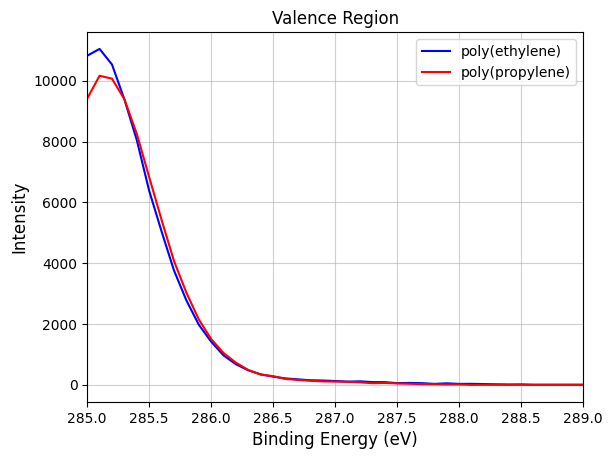

In [28]:

start_energy = 0  # Define your start energy
end_energy = 700.1  # Define your end energy
increment = 0.1  # Define your energy increment

BE_axis_full = np.arange(start_energy,end_energy, increment)

PE= 'poly(ethylene), high density (HDPE)'
PP = 'poly(propylene) (PP)'


plt.plot(BE_axis_full, filled_data[PE], color ='blue', label = 'poly(ethylene)')
plt.plot(BE_axis_full, filled_data[PP], color ='red', label = 'poly(propylene)')
plt.grid(True, alpha = 0.6)
plt.title('Valence Region')

# --- Add Overall Figure Elements ---=
plt.xlabel("Binding Energy (eV)", fontsize=12, y=0.02)
plt.legend()
plt.xlim(285,289)
# --- !! Adjust Y-axis Super Label Position !! ---
plt.ylabel("Intensity", fontsize=12, x=0.08)
plt.savefig('my_plot.png', dpi=300)  # Save as PNG with high resolution

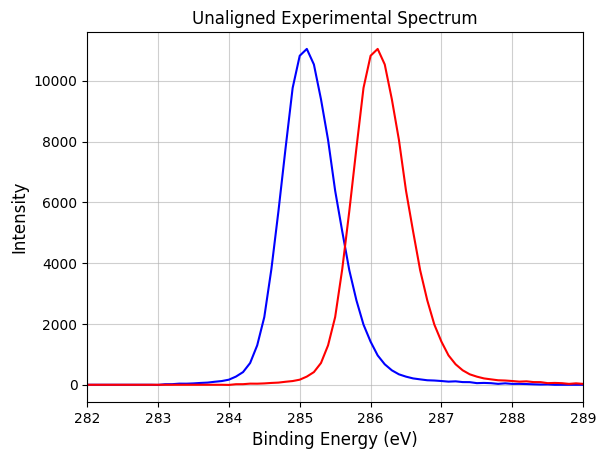

In [64]:

start_energy = 0  # Define your start energy
end_energy = 700.1  # Define your end energy
increment = 0.1  # Define your energy increment

BE_axis_full = np.arange(start_energy,end_energy, increment)

PE= 'poly(ethylene), high density (HDPE)'
PE_spectrum = filled_data[PE]
shifted_PE = shift_spectrum(filled_data[PE],10)


plt.plot(BE_axis_full, PE_spectrum, color ='blue')
plt.plot(BE_axis_full, shifted_PE, color ='red')
plt.grid(True, alpha = 0.6)
plt.title('Unaligned Experimental Spectrum')

# --- Add Overall Figure Elements ---=
plt.xlabel("Binding Energy (eV)", fontsize=12, y=0.02)
plt.xlim(282,289)
# --- !! Adjust Y-axis Super Label Position !! ---
plt.ylabel("Intensity", fontsize=12, x=0.08)
plt.savefig('my_plot.png', dpi=300)  # Save as PNG with high resolution

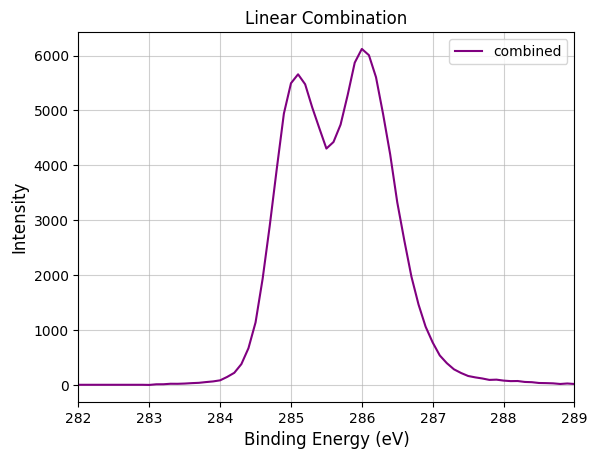

In [62]:

combined_spectrum = (PE_spectrum + shifted_PE)/2

plt.plot(BE_axis_full, combined_spectrum, color ='purple', label = 'combined')

plt.grid(True, alpha = 0.6)

# --- Add Overall Figure Elements ---=
plt.xlabel("Binding Energy (eV)", fontsize=12, y=0.02)
plt.legend()
plt.xlim(282,289)
plt.title('Linear Combination')
# --- !! Adjust Y-axis Super Label Position !! ---
plt.ylabel("Intensity", fontsize=12, x=0.08)
plt.savefig('my_plot.png', dpi=300)  # Save as PNG with high resolution

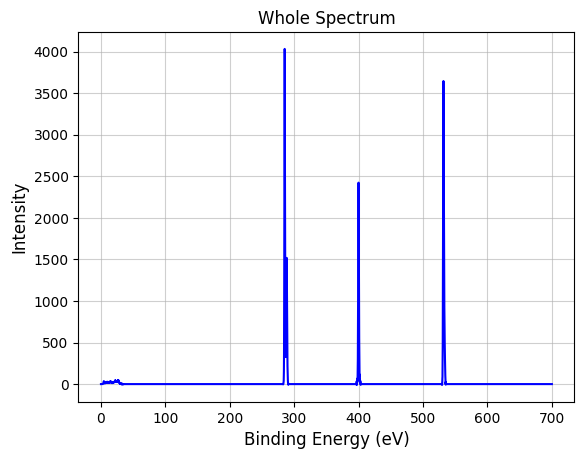

In [21]:
start_energy = 0  # Define your start energy
end_energy = 700.1  # Define your end energy
increment = 0.1  # Define your energy increment

BE_axis_full = np.arange(start_energy,end_energy, increment)

polymer_name = 'poly(acrylamide) (PAM)'


plt.plot(BE_axis_full, filled_data[polymer_name], color ='blue')
plt.grid(True, alpha = 0.6)
plt.title('Whole Spectrum')

# --- Add Overall Figure Elements ---=
plt.xlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
plt.ylabel("Intensity", fontsize=12, x=0.08)
plt.savefig('my_plot.png', dpi=300)  # Save as PNG with high resolution

/tmp/ipykernel_3581818/4117980063.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect


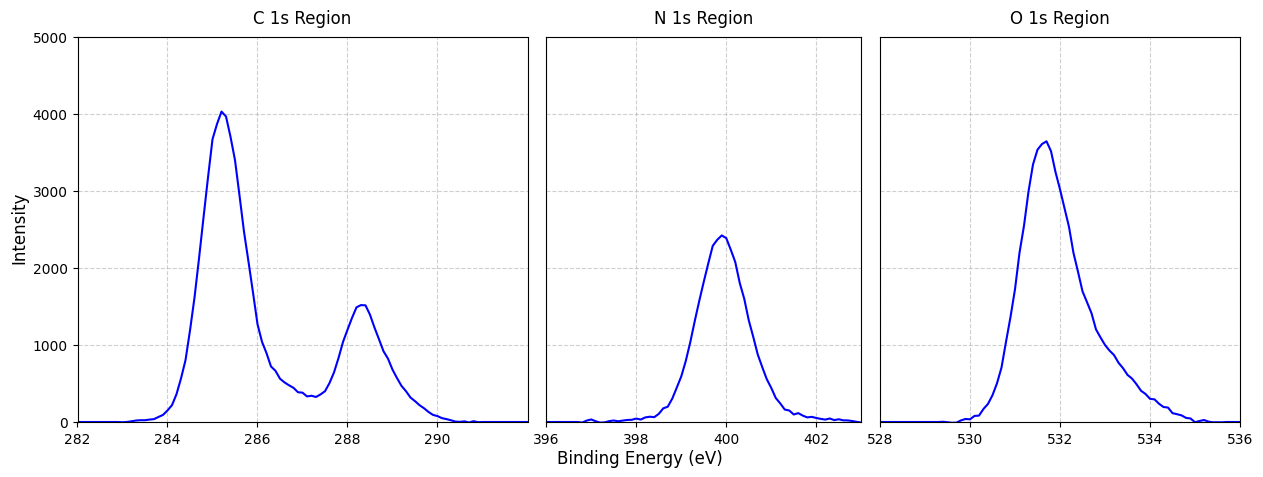

In [21]:

example_spectrum = filled_data[polymer_name] # Assuming filled_data is loaded

# --- Configuration for Zoom Regions ---
# Define ALL potential regions of interest and their titles for PEEK
all_regions = [
    (282, 292),   # Region 1: C 1s region 
    (396, 403),   # Region 2: O 1s region
    (528, 536)      # Region 3: Full Survey (Example)
]
all_region_titles = ["C 1s Region", "N 1s Region", "O 1s Region"]
include_region_1 = True
include_region_2 = True
include_region_3 = True # Set to True if you want the full survey plot as well
include_flags = [include_region_1, include_region_2, include_region_3]

# --- Tick Interval Configuration ---
x_tick_interval = 2.0 # Set desired interval (e.g., ticks every 2 eV) - adjust as needed

# --- Filter regions based on flags ---
active_regions = []
active_region_titles = []
active_widths = []
if len(all_regions) != len(all_region_titles) or len(all_regions) != len(include_flags):
    raise ValueError("Mismatch in length between regions, titles, and flags!")
for i, include in enumerate(include_flags):
    if include:
        region = all_regions[i]
        active_regions.append(region)
        active_region_titles.append(all_region_titles[i])
        active_widths.append(region[1] - region[0])
if not active_regions:
    print("No regions selected for plotting. Exiting.")
    exit() # Or handle appropriately
num_active_regions = len(active_regions)

# --- Plotting Setup (Uses filtered lists) ---
fig = plt.figure(figsize=(5 * num_active_regions, 5)) # Adjust figsize as needed
gs = fig.add_gridspec(1, num_active_regions, width_ratios=active_widths, wspace=0.05)
axes = []
for i in range(num_active_regions):
    share_y_ax = axes[0] if i > 0 else None
    ax = fig.add_subplot(gs[i], sharey=share_y_ax)
    axes.append(ax)

# --- Plotting Data on Each Active Axis ---
for i, ax in enumerate(axes):
    # Plot the simple PEEK spectrum
    ax.plot(BE_axis_full, example_spectrum, color="blue", linewidth=1.5, label=polymer_name if i == 0 else "")

    # Set the x-axis limits for the current ACTIVE region
    ax.set_xlim(*active_regions[i])

    # --- Calculate and Set Consistent Ticks ---
    xmin, xmax = ax.get_xlim()
    # Calculate the first tick >= xmin at the interval step
    start_tick = np.ceil(xmin / x_tick_interval) * x_tick_interval
    # Calculate the last tick <= xmax at the interval step
    end_tick = np.floor(xmax / x_tick_interval) * x_tick_interval

    # Generate ticks, handle cases where range is small or doesn't contain interval steps
    if start_tick > end_tick + 1e-6: # Add small epsilon for float comparison
        calculated_ticks = ax.get_xticks() # Keep default ticks if range is smaller than interval
        print(f"Warning: Region {i+1} ({xmin:.1f}-{xmax:.1f}) is smaller than tick interval {x_tick_interval}. Using default ticks.")
    elif np.isclose(start_tick, end_tick) and xmax-xmin > 0: # Avoid single tick if range has width
         calculated_ticks = np.array([start_tick]) if start_tick >= xmin and start_tick <= xmax else ax.get_xticks() # Use default if single tick outside range
    elif xmax-xmin == 0: # Handle zero width case
        calculated_ticks = [xmin]
    else:
        # Generate ticks within the calculated range
        calculated_ticks = np.arange(start_tick, end_tick + x_tick_interval * 0.1, x_tick_interval)
        # Ensure ticks are within the actual plot limits
        calculated_ticks = calculated_ticks[(calculated_ticks >= xmin) & (calculated_ticks <= xmax)]
    



    # --- Conditionally Remove Last Tick from First Axis if needed ---
   # --- !! Conditionally Remove Last Tick from First Axis !! ---
    if i == 0 and num_active_regions > 1 and len(calculated_ticks) > 1:
        final_ticks = calculated_ticks[:-1] # Remove the last calculated tick for ax1
    else:
        final_ticks = calculated_ticks # Use all calculated ticks for other axes

    ax.set_xticks(final_ticks) # Apply the calculated (and potentially trimmed) ticks

    # --- Apply Grid (Now based on consistent ticks) ---
    ax.grid(True, linestyle='--', alpha=0.6)

    # Set individual region titles
    ax.set_title(active_region_titles[i], pad=10, fontsize=12)

    # Customize y-ticks for non-first plots
    if i > 0:
        ax.tick_params(left=False, labelleft=False)

# --- Add Overall Figure Elements ---=
fig.supxlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
# Decrease the 'x' value to move it left, closer to the axis
fig.supylabel("Intensity", fontsize=12, x=0.08) # Adjust x (e.g., 0.02, 0.01)

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect
plt.grid(True)
plt.ylim(0,5000)




plt.savefig(
    'your_spectrum_filename.png', # Or your desired filename/path
    dpi=300,                   # Or your desired DPI
    bbox_inches='tight',       # Keeps tight bounding box
    facecolor='white',         # Explicitly set figure background to white
    transparent=False          # Explicitly ensure transparency is off
)

plt.show()

/tmp/ipykernel_3581818/4042378334.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.03, 0.98, 0.95]) # May need adjusting


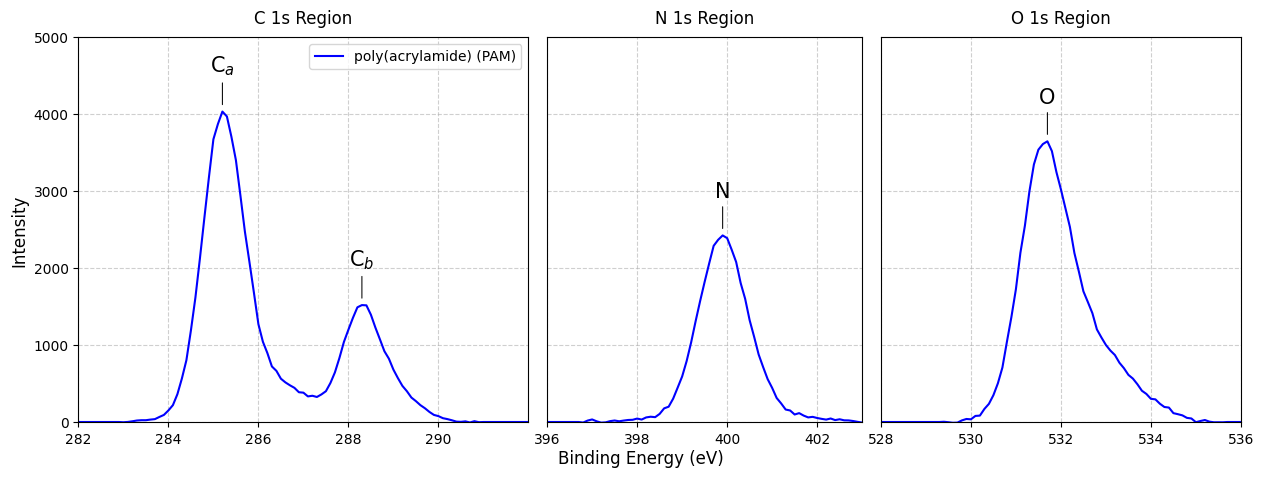

In [36]:
import matplotlib.pyplot as plt
import numpy as np
# from scipy.signal import find_peaks # Import if you want to use find_peaks later

# --- Assume previous setup code is here ---
# polymer_name = 'poly(acrylamide) (PAM)' # Make sure this is set
# BE_axis_full = ... # Make sure this is defined
# filled_data = {...} # Make sure this is loaded
# example_spectrum = filled_data[polymer_name]
# active_regions = [...]
# active_region_titles = [...]
# active_widths = [...]
# num_active_regions = len(active_regions)
# x_tick_interval = 2.0 # Make sure this is set
# -----------------------------------------

# --- Plotting Setup (Uses filtered lists) ---
fig = plt.figure(figsize=(5 * num_active_regions, 5)) # Adjust figsize as needed
gs = fig.add_gridspec(1, num_active_regions, width_ratios=active_widths, wspace=0.05)
axes = []
for i in range(num_active_regions):
    share_y_ax = axes[0] if i > 0 else None
    ax = fig.add_subplot(gs[i], sharey=share_y_ax)
    axes.append(ax)
# -----------------------------------------

# --- Plotting Data and Annotations on Each Active Axis ---
for i, ax in enumerate(axes):
    # Plot the simple spectrum
    ax.plot(BE_axis_full, example_spectrum, color="blue", linewidth=1.5, label=polymer_name if i == 0 else "")

    # Set the x-axis limits for the current ACTIVE region
    xmin, xmax = active_regions[i]
    ax.set_xlim(xmin, xmax)

    # --- Calculate and Set Consistent Ticks ---
    # (Tick calculation code remains the same as you provided)
    start_tick = np.ceil(xmin / x_tick_interval) * x_tick_interval
    end_tick = np.floor(xmax / x_tick_interval) * x_tick_interval
    if start_tick > end_tick + 1e-6:
        calculated_ticks = ax.get_xticks()
        print(f"Warning: Region {i+1} ({xmin:.1f}-{xmax:.1f}) is smaller than tick interval {x_tick_interval}. Using default ticks.")
    elif np.isclose(start_tick, end_tick) and xmax-xmin > 0:
         calculated_ticks = np.array([start_tick]) if start_tick >= xmin and start_tick <= xmax else ax.get_xticks()
    elif xmax-xmin == 0:
        calculated_ticks = [xmin]
    else:
        calculated_ticks = np.arange(start_tick, end_tick + x_tick_interval * 0.1, x_tick_interval)
        calculated_ticks = calculated_ticks[(calculated_ticks >= xmin) & (calculated_ticks <= xmax)]

    # Conditional tick removal (same as before, maybe tweak logic if needed)
    if i == 0 and num_active_regions > 1 and len(calculated_ticks) > 1:
         final_ticks = calculated_ticks[:-1]
    else:
         final_ticks = calculated_ticks

    ax.set_xticks(final_ticks) # Apply the calculated (and potentially trimmed) ticks

    # --- Apply FULL Grid to ALL axes ---
    ax.grid(True, linestyle='--', alpha=0.6) # Apply H and V grid to this axis

    # Set individual region titles
    ax.set_title(active_region_titles[i], pad=10, fontsize=12)

    # --- Customize Y-axis appearance (Labels/Ticks) ---
    if i == 0:
        ax.set_ylabel("Intensity", fontsize=12) # Set Y label only on first axis
    else:
        ax.tick_params(axis='y', left=False, labelleft=False) # Remove Y ticks/labels on others

    # --- *** ADD ANNOTATIONS WITH ARROWS *** ---
    ymin, ymax = ax.get_ylim()
    offset = (ymax - ymin) * 0.10 # Vertical offset for text above peak (5% of y-range)
    arrow_props = dict(
        arrowstyle="-", # Style of the line/arrow (just a line)
        connectionstyle="arc3", # Straight line connection
        color='black',         # Arrow color
        lw=0.75,               # Line width for the arrow
        shrinkB=5             # Gap (in points) between text and arrow start
    )

    if i == 0: # C 1s Region
        # Manual placement for expected PAM C 1s peaks
        # ** ADJUST THESE BE VALUES BASED ON YOUR DATA **
        be_ca = 285.2
        be_cb = 288.3

        # Find intensity near target BEs
        idx_ca = np.argmin(np.abs(BE_axis_full - be_ca))
        y_ca = example_spectrum[idx_ca]
        idx_cb = np.argmin(np.abs(BE_axis_full - be_cb))
        y_cb = example_spectrum[idx_cb]

        # Add annotation for C_a
        ax.annotate(
            'C$_a$', xy=(be_ca, y_ca), xytext=(be_ca, y_ca + offset),
            ha='center', va='bottom', color='black', fontsize=15,
            arrowprops=arrow_props
        )
        # Add annotation for C_b
        ax.annotate(
            'C$_b$', xy=(be_cb, y_cb), xytext=(be_cb, y_cb + offset),
            ha='center', va='bottom', color='black', fontsize=15,
            arrowprops=arrow_props
        )

    elif i == 1: # N 1s Region
        # Find the max peak in the displayed region automatically
        mask = (BE_axis_full >= xmin) & (BE_axis_full <= xmax)
        if np.any(mask):
            region_be = BE_axis_full[mask]
            region_intens = example_spectrum[mask]
            peak_idx_in_region = np.argmax(region_intens)
            peak_x = region_be[peak_idx_in_region]
            peak_y = region_intens[peak_idx_in_region]
            ax.annotate(
                'N', xy=(peak_x, peak_y), xytext=(peak_x, peak_y + offset),
                ha='center', va='bottom', color='black', fontsize=15,
                arrowprops=arrow_props
            )

    elif i == 2: # O 1s Region
        # Find the max peak in the displayed region automatically
        mask = (BE_axis_full >= xmin) & (BE_axis_full <= xmax)
        if np.any(mask):
            region_be = BE_axis_full[mask]
            region_intens = example_spectrum[mask]
            peak_idx_in_region = np.argmax(region_intens)
            peak_x = region_be[peak_idx_in_region]
            peak_y = region_intens[peak_idx_in_region]
            ax.annotate(
                'O', xy=(peak_x, peak_y), xytext=(peak_x, peak_y + offset),
                ha='center', va='bottom', color='black', fontsize=15,
                arrowprops=arrow_props
            )
    # Add more elif conditions here if you have more regions/axes

# --- Add Overall Figure Elements ---
fig.supxlabel("Binding Energy (eV)", fontsize=12, y=0.02)
# Removed fig.supylabel as ylabel is now on first axis

# Add legend only if label was set (on first plot)
if axes and axes[0].get_legend_handles_labels()[1]:
     axes[0].legend(loc='upper right') # Adjust legend position as needed

# --- Adjust Layout ---
# Option 1: Try tight_layout (might need adjustment or fail)
try:
    plt.tight_layout(rect=[0.03, 0.03, 0.98, 0.95]) # May need adjusting
except Exception as e:
    print(f"Tight layout failed: {e}. Consider constrained_layout=True or subplots_adjust.")
    # Option 2: Fallback to subplots_adjust if tight_layout fails
    # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.1)
    # Option 3: Use constrained_layout=True when creating the figure instead.


plt.ylim(0,5000)
# --- Save the Figure ---
plt.savefig(
    f'{polymer_name}_annotated_spectrum_v2.png', # New filename
    dpi=300,
    # bbox_inches='tight', # Tight might clip annotations sometimes, test without first
    bbox_inches='tight',       # Keeps tight bounding box
    facecolor='white',
    transparent=False
)


plt.show()

plot generated spectra

In [13]:

def apply_specific_shift(spectrum, shift):
    '''
    Applies a random horizontal shift to the entire spectrum sequence.
    Args:
        spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        shifted_spectrum
    '''
    # Create an array of zeros with the same length as the original spectrum
    shifted_spectrum = np.zeros_like(spectrum)

    if shift > 0:
        # Shift to the right
        shifted_spectrum[shift:] = spectrum[:-shift]
    elif shift < 0:
        # Shift to the left
        shifted_spectrum[:shift] = spectrum[-shift:]
    else:
        # No shift, return the original spectrum
        shifted_spectrum = spectrum.copy()

    shifted_spectrum = shifted_spectrum[:len(spectrum)]
    return shifted_spectrum


10
Using Kernel size: 61 points (~6.00 eV)


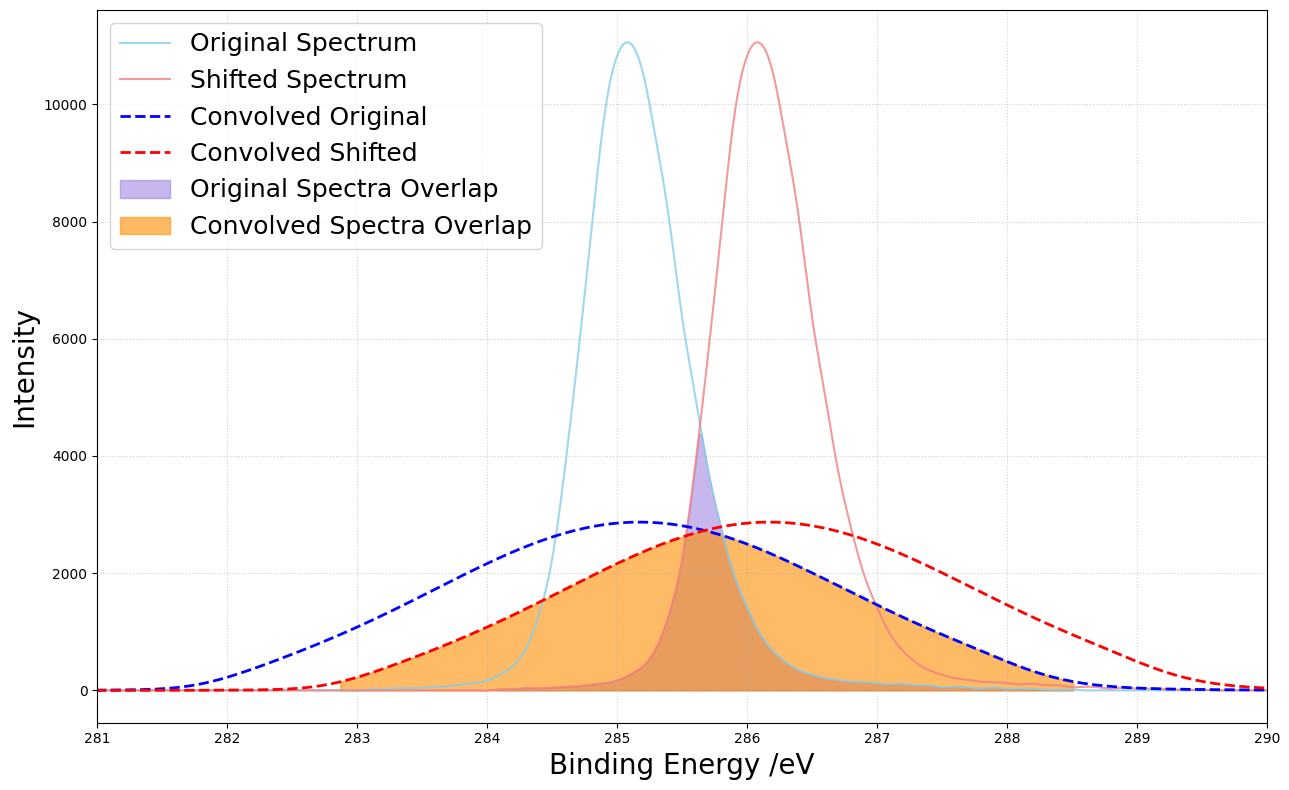

In [83]:
from scipy.signal import convolve
from scipy.stats import norm # Needed for Gaussian kernel
from scipy.interpolate import interp1d # Import interpolation function


energy_step = 0.1
shift_amount_ev = 1 #ev
shift_amount_index = int(shift_amount_ev/energy_step)
print(shift_amount_index)

BE_values = create_uniform_energy_grid(start_energy, end_energy)[valence_region_index:]
PE_spectrum = filled_data['poly(ethylene), high density (HDPE)'][valence_region_index:]

shifted_PE_spectrum = apply_specific_shift(PE_spectrum, shift_amount_index)

# Kernel definition
kernel_width_ev = shift_amount_ev * 6 # eV - User value: 6 times the shift
kernel_size_points = int(kernel_width_ev / energy_step)

if kernel_size_points % 2 == 0:
    kernel_size_points += 1
kernel_size_points = max(3, kernel_size_points)

print(f"Using Kernel size: {kernel_size_points} points (~{kernel_width_ev:.2f} eV)")

kernel_x = np.linspace(-kernel_width_ev / 2, kernel_width_ev / 2, kernel_size_points)
kernel_sigma = kernel_width_ev / 4
kernel = norm.pdf(kernel_x, 0, kernel_sigma)
kernel = kernel / np.sum(kernel)

# Convolution
convolved_original = convolve(PE_spectrum, kernel, mode='same')
convolved_shifted = convolve(shifted_PE_spectrum, kernel, mode='same')
#Find Peak Locations (Required for thresholding, but not plotting markers) ---
original_peak_idx = np.argmax(PE_spectrum)
shifted_peak_idx = np.argmax(shifted_PE_spectrum)
convolved_original_peak_idx = np.argmax(convolved_original)
convolved_shifted_peak_idx = np.argmax(convolved_shifted)

# Get intensities for threshold calculation
original_peak_intensity = PE_spectrum[original_peak_idx]
shifted_peak_intensity = shifted_PE_spectrum[shifted_peak_idx]
convolved_original_peak_intensity = convolved_original[convolved_original_peak_idx]
convolved_shifted_peak_intensity = convolved_shifted[convolved_shifted_peak_idx]

# --- Define Colors ---
color_orig = 'skyblue'
color_shifted = 'lightcoral'
color_conv_orig = 'blue'
color_conv_shifted = 'red'
color_overlap_orig = 'mediumpurple'
color_overlap_conv = 'darkorange'

# --- Define Font Sizes ---
title_fontsize = 18
label_fontsize = 20
legend_fontsize = 18


# --- Interpolation Setup ---
# Create interpolation functions based on your original data
interp_kind = 'cubic' # Or 'linear', 'quadratic'. Cubic is usually smooth.
f_original = interp1d(BE_values, PE_spectrum, kind=interp_kind, bounds_error=False, fill_value=0)
f_shifted = interp1d(BE_values, shifted_PE_spectrum, kind=interp_kind, bounds_error=False, fill_value=0)
f_conv_original = interp1d(BE_values, convolved_original, kind=interp_kind, bounds_error=False, fill_value=0)
f_conv_shifted = interp1d(BE_values, convolved_shifted, kind=interp_kind, bounds_error=False, fill_value=0)

# Create a denser energy axis for smoother plotting
num_interp_points = len(BE_values) * 5 # Increase density (e.g., 5x)
BE_values_interp = np.linspace(BE_values.min(), BE_values.max(), num_interp_points)

# Generate interpolated (smoother) spectra
PE_spectrum_interp = f_original(BE_values_interp)
shifted_PE_spectrum_interp = f_shifted(BE_values_interp)
convolved_original_interp = f_conv_original(BE_values_interp)
convolved_shifted_interp = f_conv_shifted(BE_values_interp)

# --- Find Peak Locations (Required for thresholding - use original data) ---
original_peak_idx = np.argmax(PE_spectrum)
shifted_peak_idx = np.argmax(shifted_PE_spectrum)
convolved_original_peak_idx = np.argmax(convolved_original)
convolved_shifted_peak_idx = np.argmax(convolved_shifted)
# Get original peak intensities for threshold calculation & y-limits
original_peak_intensity = PE_spectrum[original_peak_idx]
shifted_peak_intensity = shifted_PE_spectrum[shifted_peak_idx]
convolved_original_peak_intensity = convolved_original[convolved_original_peak_idx] # Needed for its threshold
convolved_shifted_peak_intensity = convolved_shifted[convolved_shifted_peak_idx] # Needed for its threshold

# --- Interpolation Setup (Run once) ---
interp_kind = 'cubic'
f_original = interp1d(BE_values, PE_spectrum, kind=interp_kind, bounds_error=False, fill_value=0)
f_shifted = interp1d(BE_values, shifted_PE_spectrum, kind=interp_kind, bounds_error=False, fill_value=0)
f_conv_original = interp1d(BE_values, convolved_original, kind=interp_kind, bounds_error=False, fill_value=0)
f_conv_shifted = interp1d(BE_values, convolved_shifted, kind=interp_kind, bounds_error=False, fill_value=0)

num_interp_points = len(BE_values) * 5
BE_values_interp = np.linspace(BE_values.min(), BE_values.max(), num_interp_points)

PE_spectrum_interp = f_original(BE_values_interp)
shifted_PE_spectrum_interp = f_shifted(BE_values_interp)
convolved_original_interp = f_conv_original(BE_values_interp)
convolved_shifted_interp = f_conv_shifted(BE_values_interp)

# --- Define Colors & Font Sizes (Run once) ---
color_orig = 'skyblue'
color_shifted = 'lightcoral'
color_conv_orig = 'blue'
color_conv_shifted = 'red'
color_overlap_orig = 'mediumpurple'
color_overlap_conv = 'darkorange'

# --- Create Main Plot ---
plt.figure(figsize=(13, 8)) # Only one main figure

# Plot INTERPOLATED spectra with SWAPPED Linestyles
plt.plot(BE_values_interp, PE_spectrum_interp, '-', color=color_orig, alpha=0.8, label='Original Spectrum') # SOLID
plt.plot(BE_values_interp, shifted_PE_spectrum_interp, '-', color=color_shifted, alpha=0.8, label='Shifted Spectrum') # SOLID
plt.plot(BE_values_interp, convolved_original_interp, '--', color=color_conv_orig, linewidth=2, label='Convolved Original') # DASHED
plt.plot(BE_values_interp, convolved_shifted_interp, '--', color=color_conv_shifted, linewidth=2, label='Convolved Shifted') # DASHED


# --- Highlight Overlap Regions (Using np.minimum on INTERPOLATED data) ---
# Using the low threshold you set (0.001 * max). Adjust if it includes too much baseline.
overlap_threshold = 0.001 * max(original_peak_intensity, shifted_peak_intensity)
overlap_orig_indices = np.where((PE_spectrum_interp > overlap_threshold) & (shifted_PE_spectrum_interp > overlap_threshold))[0]
if len(overlap_orig_indices) > 0:
    plt.fill_between(BE_values_interp[overlap_orig_indices], 0,
                     np.minimum(PE_spectrum_interp[overlap_orig_indices], shifted_PE_spectrum_interp[overlap_orig_indices]),
                     color=color_overlap_orig, alpha=0.5,
                     label='Original Spectra Overlap')

# Using the previous threshold for convolved overlap.
overlap_conv_threshold = 0.05 * max(convolved_original_peak_intensity, convolved_shifted_peak_intensity)
overlap_conv_indices = np.where((convolved_original_interp > overlap_conv_threshold) & (convolved_shifted_interp > overlap_conv_threshold))[0]
if len(overlap_conv_indices) > 0:
     plt.fill_between(BE_values_interp[overlap_conv_indices], 0,
                      np.minimum(convolved_original_interp[overlap_conv_indices], convolved_shifted_interp[overlap_conv_indices]),
                      color=color_overlap_conv, alpha=0.6,
                      label='Convolved Spectra Overlap')

# --- Labels, Title, Grid ---
plt.xlabel('Binding Energy /eV', fontsize=label_fontsize)
plt.ylabel('Intensity', fontsize=label_fontsize)
plt.grid(True, linestyle=':', alpha=0.6)

# --- Final Plot Settings ---
plt.xlim(281, 290) # Your x-limits
plt.ylim(bottom= -0.05 * max(original_peak_intensity, shifted_peak_intensity)) # Use original intensity for limit

# Legend
plt.legend(loc='upper left', fontsize=legend_fontsize)

plt.tight_layout()
plt.show() # Display the main plot


0.9999999999999999
1.0000000000000002
0.9999999999999993
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999994
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999996
0.9999999999999992
1.0000000000000002
1.000000000000001
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999997
1.0000000000000007
1.0000000000000002
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0
1.0


<function matplotlib.pyplot.show(close=None, block=None)>

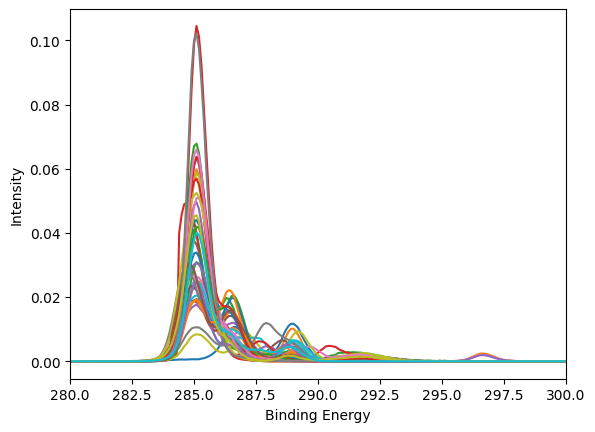

In [ ]:
BE_values = create_uniform_energy_grid(start_energy, end_energy)[valence_region_index:]

for i in range(40):
    print(sum(spectra[i]))
    plt.plot(BE_values, spectra[i])
    plt.xlabel('Binding Energy')
    plt.ylabel('Intensity')

plt.savefig('generated_xps_overlay')
plt.xlim(280,300)
plt.show

Save example plots of generated synthetic spectra:

In [10]:
plots_dir = Path( '../reports/synth_plots_examples')

for i in range(8):
    plt.plot(BE_values,spectra[i])
    # Get the label and display it in a box
    label_text = label_converter(labels[i][:-1])

    if not label_text:
        box = 'no functional groups'
    else:
        box = "\n".join(label_text)
        
    plt.text(0.95, 0.95, box, 
             ha='right', va='top',  # Horizontal and vertical alignment
             fontsize=10, 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
             transform=plt.gca().transAxes)  # Place box in top right

    plt.xlabel('Binding Energy')
    plt.ylabel('Intensity')

    plt.savefig(os.path.join(plots_dir, 'spectrum_{}.png'.format(i)))
    plt.clf()



NameError: name 'BE_values' is not defined

info on alkane carbon reference:

In [67]:
#indexes to eV'


valence_range = 40 #range for core electron binding energy peaks eV
valence_region_index= int(valence_range/0.1)
expected_max_shift = 0.5
expected_max_shift_index = int(expected_max_shift/0.1)

reference_carbon_peak = normalize_spectrum_by_area(filled_data['poly(ethylene), high density (HDPE)'][valence_region_index:])
ref_peak_index = np.argmax(reference_carbon_peak)
ref_peak_energy = (ref_peak_index + valence_region_index)*0.1
print(valence_region_index)
print(ref_peak_energy)


400
285.1


problem spectrum: poly(4-hydroxystyrene) (PHS)
problem spectrum: poly(diallyl isophthalate) (PDAiP)
problem spectrum: poly(bisphenol A carbonate) (PBAC)
problem spectrum: poly(2-ethyl-2-oxazoline) (PEOx)
problem spectrum: poly(diallyl phthalate) (PDAP)


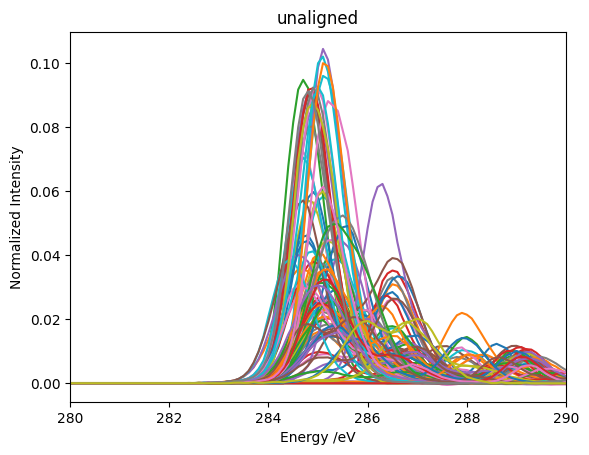

ValueError: x and y must have same first dimension, but have shapes (6602,) and (6601,)

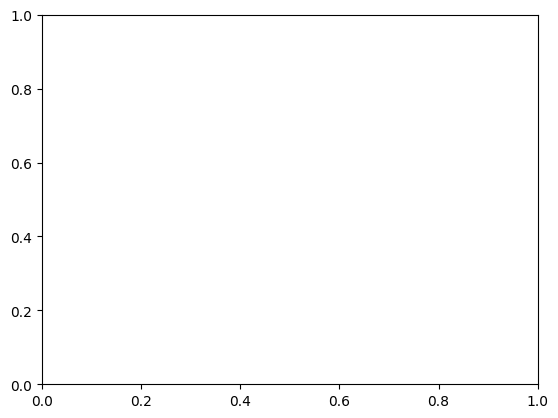

In [69]:
BE_values = create_uniform_energy_grid(start_energy, end_energy)[valence_region_index:]

problem_spectra = [
    'poly(diallyl isophthalate) (PDAiP)',
    'poly(4-hydroxystyrene) (PHS)', 
    'poly(bisphenol A carbonate) (PBAC)',
    'poly(diallyl phthalate) (PDAP)',
    'poly(2-ethyl-2-oxazoline) (PEOx)'
]
                                                                                                                

plt.figure()
for polymer_name, unaligned_spectrum in unaligned_data.items():
    label = relative_labels[polymer_name]
    if polymer_name not in problem_spectra:
         plt.plot(BE_values[:-1], unaligned_spectrum)
            
    else:
        print(f'problem spectrum: {polymer_name}')

plt.title(f'unaligned')
plt.xlabel('Energy /eV')
plt.ylabel('Normalized Intensity')
plt.xlim(280,290)
plt.show()



for polymer_name, aligned_spectrum in standardised_data.items():
    label = relative_labels[polymer_name]
    if polymer_name not in problem_spectra:
         plt.plot(BE_values, aligned_spectrum)
         if aligned_spectrum[2440] > 0.01:
             print(f'mishandeled shoulder: {polymer_name}')


plt.title(f'aligned')
plt.xlabel('Energy /eV')
plt.ylabel('Normalized Intensity')
plt.xlim(280,290)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6602,) and (6601,)

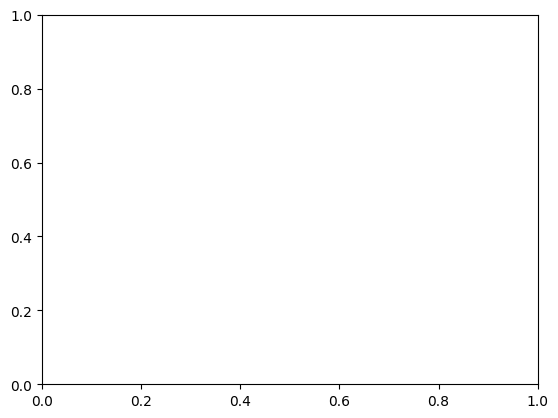

In [ ]:
import matplotlib.pyplot as plt

# Shared settings
x_pos = 285.1
x_range = (282, 292)
xticks = list(range(x_range[0], x_range[1] + 1))  # every 1 eV
label_fontsize = 12
title_fontsize = 14

# First Plot (Unaligned)
plt.figure()
for polymer_name, unaligned_spectrum in unaligned_data.items():
    if polymer_name in shifted_polymers:
        label = relative_labels[polymer_name]
        if polymer_name not in problem_spectra:
            if label[-1] - sum(label[:-1]) > 1:
                plt.plot(BE_values, unaligned_spectrum)
        else:
            print(f'problem spectrum: {polymer_name}')

plt.title('Unaligned Spectra', fontsize=title_fontsize)
plt.xlabel('Binding Energy (eV)', fontsize=label_fontsize)
plt.ylabel('Normalized Intensity', fontsize=label_fontsize)
plt.xlim(x_range)
plt.xticks(xticks)

plt.axvline(x=x_pos, color='r', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
# Second Plot (Aligned)
plt.figure()
for polymer_name, aligned_spectrum in standardised_data.items():
    if polymer_name in shifted_polymers:
        label = relative_labels[polymer_name]
        if polymer_name not in problem_spectra:
            if label[-1] - sum(label[:-1]) > 1:
                plt.plot(BE_values, aligned_spectrum)

plt.title('Aligned Spectra', fontsize=title_fontsize)
plt.xlabel('Binding Energy (eV)', fontsize=label_fontsize)
plt.ylabel('Normalized Intensity', fontsize=label_fontsize)
plt.xlim(x_range)
plt.xticks(xticks)

# Add labeled vertical reference line as a series
plt.axvline(x=x_pos, color='r', linestyle='--', linewidth=1,
            label='Polyethene reference: 285.1 eV')

plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()



demonstrate Gaussian broadening process 

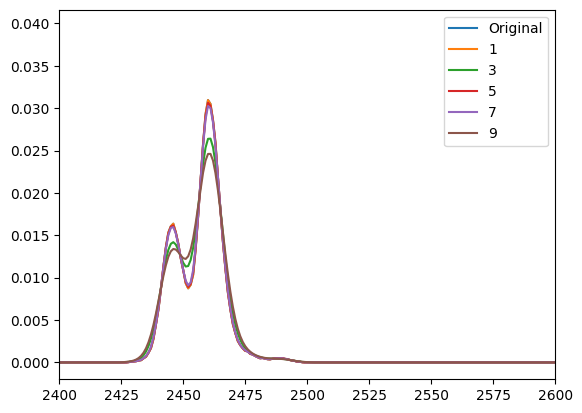

In [ ]:
unbroadened_example = standardised_data['poly(vinyl methyl ether) (PVME)']
plt.plot(unbroadened_example, label=f'Original')


sigma_range = range(1,10,2)

for sigma in sigma_range:
    broad = gaussian_broadening(unbroadened_example, sigma)
    plt.plot(broad, label = sigma)




plt.xlim(2400,2600)
plt.legend()
plt.show()


plot of half normal distribution for randomising sigma (conv kernel)

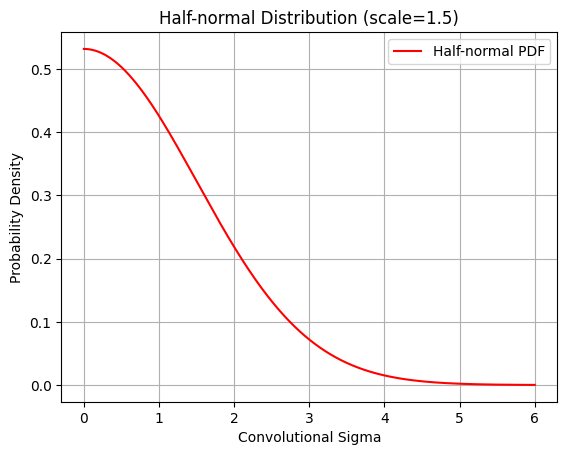

In [ ]:
scale = 1.5 # std dev. for half-normal distribution
samples = 1000000
x = np.linspace(0, 6, 1000)  # Create x values from 0 to 6
y = 1/(scale * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*scale**2))  # Half-normal distribution PDF
y = y * 2  # Multiply by 2 since we're only showing positive half

plt.plot(x, y, 'r-', label='Half-normal PDF')
plt.xlabel('Convolutional Sigma')
plt.ylabel('Probability Density')
plt.title(f'Half-normal Distribution (scale={scale})')
plt.grid(True)
plt.legend()
plt.show()

plot overlay of all synthetic spectra:

Plot all original spectra:

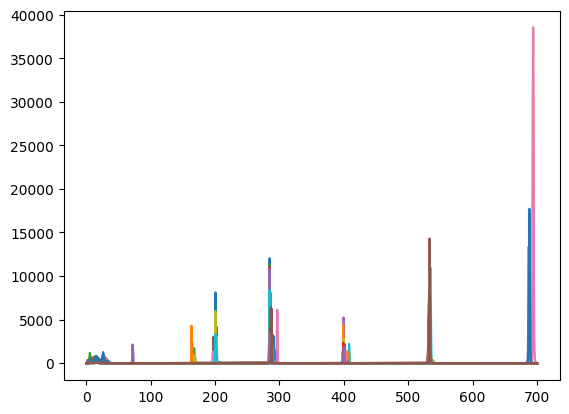

In [113]:
for polymer, data in filled_data.items():
    plt.plot(BE_values, pd.DataFrame(data))
plt.show()

# Troubleshooting Tools


81006.1654642997


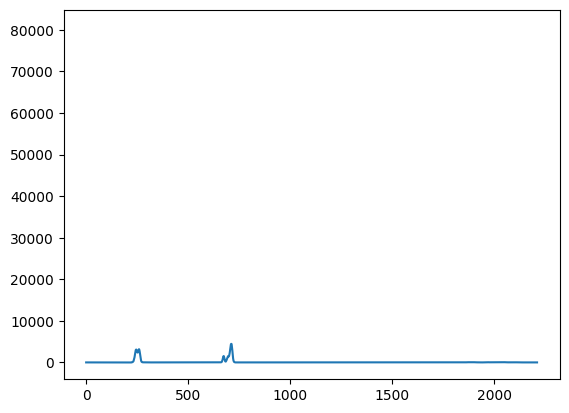

In [27]:
import scipy

def apply_horizontal_shift(spectrum, max_shift):
    '''
    Applies a random horizontal shift to the entire spectrum sequence.
    Args:
        spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        shifted_spectrum
    '''
    shift = random.randint(-max_shift, max_shift)
    # Create an array of zeros with the same length as the original spectrum
    shifted_spectrum = np.zeros_like(spectrum)

    if shift > 0:
        # Shift to the right
        shifted_spectrum[shift:] = spectrum[:-shift]
    elif shift < 0:
        # Shift to the left
        shifted_spectrum[:shift] = spectrum[-shift:]
    else:
        # No shift, return the original spectrum
        shifted_spectrum = spectrum.copy()

    shifted_spectrum = shifted_spectrum[:len(spectrum)]
    return shifted_spectrum

def gaussian_broadening(spectrum, sigma):
    # Broaden the entire spectrum
    x = np.linspace(-3*sigma, 3*sigma, len(spectrum))
    gaussian = np.exp(-(x/sigma)**2/2)
    broadened_spectrum = np.convolve(spectrum, gaussian, mode='same')
    
    return broadened_spectrum


def all_effects(spectrum):
    out_put_spectrum = apply_horizontal_shift(gaussian_broadening(spectrum))
    return out_put_spectrum


max_shift = 100
test = xps_data[0][xps_data[2][3]]
new_plot = gaussian_broadening(test, max_shift)

plt.plot(test)
plt.plot(new_plot[0])
print(new_plot[1])



check for synthetic specra containing no functional groups:

In [124]:
for i, label in enumerate(labels): 
    if all(v == 0 for v in label):
        print(f"Index {i}: All zeros")

        plt.plot(spectra[i])
        # Get the label and display it in a box
        label_text = label_converter(labels[i])

        if not label_text:
            box = 'no functional groups'
        else:
            box = "\n".join(label_text)
            
        plt.text(0.95, 0.95, box, 
                ha='right', va='top',  # Horizontal and vertical alignment
                fontsize=10, 
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
                transform=plt.gca().transAxes)  # Place box in top right

plt.show()

investigating gaps in original spectra:

In [125]:
CEL_spec = os.path.join(data_path, 'cellulose triacetate (CTA)', 'cellulose triacetate') + '.xlsx'
df_f = pd.read_excel(CEL_spec, sheet_name='All')
binding_energy =  np.array(df_f['Binding Energy'][::-1])

print(len(binding_energy))

# Check if values in binding_energies are evenly spaced intervals
spacing = np.diff(binding_energy)
if np.allclose(spacing, spacing[0]):
    print("Values in binding_energies are evenly spaced intervals")
    print(f"Range of intervals: min={np.min(spacing)}, max={np.max(spacing)}")
else:
    print("Values in binding_energies are not evenly spaced intervals")
    print(f"Range of intervals: min={np.min(spacing)}, max={np.max(spacing)}")
    max_spacing_index = np.argmax(spacing)
    print(f"Index of maximum spacing: {max_spacing_index}")
    # Print indexes for all intervals greater than 0.1 as a dataframe

    intervals_df = pd.DataFrame({'Index': np.where(spacing > 0.11)[0], 'Interval': spacing[spacing > 0.11], 'Binding Energy': binding_energy[np.where(spacing > 0.11)[0]]})
    print(intervals_df)

2210
Values in binding_energies are not evenly spaced intervals
Range of intervals: min=0.09999999999990905, max=142.0
Index of maximum spacing: 2028
   Index  Interval  Binding Energy
0    450      20.0            40.0
1    751       7.4            90.0
2    851      21.0           107.3
3   1052      12.7           148.3
4   1254      14.9           181.1
5   1395      65.0           210.0
6   1646      92.0           300.0
7   1827     110.0           410.0
8   2028     142.0           540.0


Investigating problematic (cut-off) spectra:

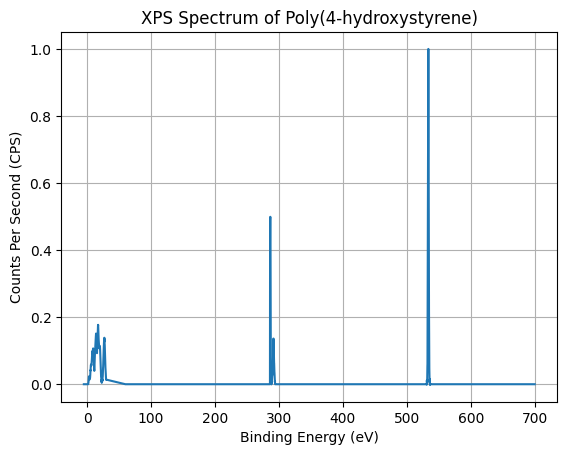

In [126]:
# Read and plot PHS data
import pandas as pd
import matplotlib.pyplot as plt

# Read the PHS data
phs_data = pd.read_csv("../data/experimental_data/poly(4-hydroxystyrene) (PHS)/PHS.csv")



# Create the plot
plt.figure()
plt.plot(phs_data['Binding Energy'], phs_data['CPS'])
plt.xlabel('Binding Energy (eV)')
plt.ylabel('Counts Per Second (CPS)') 
plt.title('XPS Spectrum of Poly(4-hydroxystyrene)')
plt.grid(True)
plt.show()
